<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#In-This-Notebook" data-toc-modified-id="In-This-Notebook-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>In This Notebook</a></span></li><li><span><a href="#Starting-Point" data-toc-modified-id="Starting-Point-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Starting Point</a></span></li></ul></div>

# In This Notebook

**To Do:**
- ...

# Starting Point
coco_labeledbbox_show_methods

0.002754228748381138


epoch,train_loss,valid_loss,mse,cel,acc,time
0,4.444686,2.049105,0.356303,0.267592,0.928016,00:13
1,2.451194,1.027690,0.121151,0.421934,0.868677,00:13
2,1.262392,0.668065,0.077129,0.282417,0.918288,00:13
3,0.788398,0.735039,0.068973,0.390174,0.885214,00:13
4,0.575398,0.628634,0.062474,0.316265,0.906615,00:13
5,0.455552,0.549364,0.053676,0.280984,0.917315,00:14
6,0.314614,0.436349,0.043222,0.220240,0.946498,00:14
7,0.227740,0.333160,0.038156,0.142381,0.963035,00:13
8,0.174227,0.310016,0.033731,0.141361,0.960117,00:14
9,0.152118,0.291283,0.031253,0.135018,0.960117,00:14


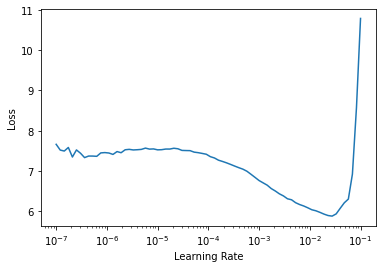

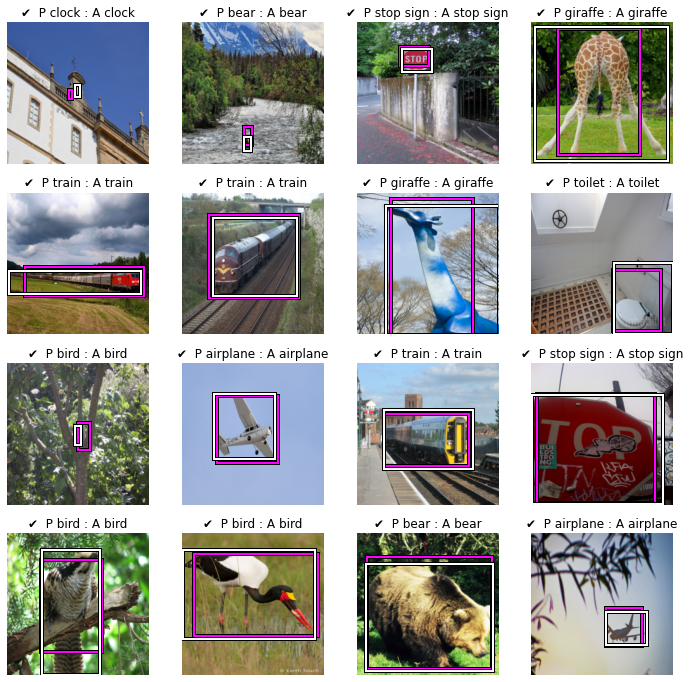

In [ ]:
from fastai.vision.all import *


### Params ###
im_size      = 224
batch_size   = 64
path         = Path('/home/rory/data/coco2017')
valid_split  = .15


### Load data (singles) ###
# Grab cols
def grab_cols(df, cols):
    """Expects: DataFrame df; str or list of strs cols. Returns: L or an LoL."""
    def _grab_col(df, col):
        return L((ColReader(col)(df)).to_list())
    
    if isinstance(cols, str): return _grab_col(df, cols)
    if len(cols)==1: return _grab_col(df, cols)
    if len(cols)>=2:
        r=L()
        for c in cols:
            r.append(_grab_col(df,c))
        return r
df = pd.read_pickle(path/'singles.pkl')
imp, lbl, bbox = grab_cols(df, ['im','lbl','bbox'])
bbox = bbox.map(lambda x:list(x)) # fixed pickle bug; lists incorrectly unpickled as tups
# Create getters for pipeline
imp2lbl  = {p:l for p,l in zip(imp,lbl)}
imp2bbox = {p:b for p,b in zip(imp,bbox)}
def get_lbl(p):  return imp2lbl[p]
def get_bbox(p): return imp2bbox[p]


### Datasets ###
dss_tfms = [[PILImage.create],
            [get_bbox, TensorBBox.create],
            [get_lbl, Categorize()]]
splits = RandomSplitter(valid_split)(imp)
dss = Datasets(imp, tfms=dss_tfms, splits=splits)


### DataLoaders ###
cpu_tfms = [BBoxLabeler(), PointScaler(), Resize(im_size, method='squish'), ToTensor()]
gpu_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]
dls = dss.dataloaders(bs=batch_size,after_item=cpu_tfms,after_batch=gpu_tfms,drop_last=True)
dls.n_inp = 1


### Model ###
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head

    def forward(self, x):
        return self.head(self.body(x))
body = create_body(resnet34, pretrained=True)
head = create_head(1024, 4+dss.c, ps=0.5)
mod  = custom_module(body, head)


### Loss ###
def mse(f, bb, lbl): return MSELossFlat()(f[:,:4], torch.squeeze(bb))
def cel(f, bb, lbl): return CrossEntropyLossFlat()(f[:,4:], lbl)
def lbb_loss(f, bb, lbl): return 5*mse(f,bb,lbl) + cel(f,bb,lbl)
def acc(f, bb, lbl): return accuracy(f[:,4:], lbl)


### Training ###
learner = Learner(dls, mod, loss_func=lbb_loss, metrics=[mse, cel, acc])
lr_min, _ = learner.lr_find(); print("lr_min:", lr_min)
learner.fit_one_cycle(10, lr=lr_min)


### Results ###
def view_results(learner, n=16, nrows=4, ncols=4, offset=0):
    # get batch of ims & targs, get preds
    ims, targ_bbs, targ_lbls = learner.dls.one_batch()
    preds = learner.model(ims)
    pred_bbs, pred_lbls = preds[:,:4], preds[:,4:].argmax(dim=-1)
    decoded_ims = Pipeline(gpu_tfms).decode(ims)
    
    # show grid results
    for i,ctx in enumerate(get_grid(n, nrows, ncols)):
        idx = i+offset*n
        # title
        pred_cls = dls.vocab[pred_lbls[idx].item()]
        targ_cls = dls.vocab[targ_lbls[idx].item()]
        icon = '✔️' if pred_cls==targ_cls else '✖️'
        title = f"{icon}  P {pred_cls} : A {targ_cls}"
        # im
        show_image(decoded_ims[idx], ctx=ctx, title=title)
        # bbs
        pred_bb = TensorBBox(pred_bbs[idx])
        targ_bb = TensorBBox(targ_bbs[idx])
        ((pred_bb+1)*224//2).show(ctx=ctx, color='magenta')
        ((targ_bb+1)*224//2).show(ctx=ctx);
view_results(learner)